In [4]:
import pandas as pd
import pyarrow
from datetime import datetime, timedelta
import calendar
from prophet import Prophet
from sklearn.model_selection import train_test_split

## Input data 

In [5]:
input_df=pd.read_parquet('data/input_data.parquet')

## Input holidays 

The data represents the daily rate of DPD30+ for a banking product, with a monthly due date on the 4th of each month. If the customer does not make a payment, the DPD will reach 30 exactly 30 days after the due date. The date_diff variable captures the difference between the current date and the nearest 4th day of the month. For instance, when date_diff = 29 (counting from 0), it indicates a special point for the model to predict, as it is the day before the DPD reaches 30.

In Prophet, holidays are treated as special events that can cause unusual behavior in the time series. 
These events, such as specific dates or occurrences, are modeled separately from the regular trend and seasonality. 
By including holidays as inputs, the model can give more attention to these dates, allowing it to adjust the trend accordingly and account for any spikes or drops that might occur during these periods.
This helps Prophet accurately capture the impact of holidays on the time series, ensuring that these fluctuations are considered in the model's predictions.

In [8]:
holiday_dates = input_df[input_df['date_diff'].isin( [29])]['date_balance']

# Define holidays DataFrame for Prophet
holidays = pd.DataFrame({
    'holiday': 'new_cycle',
    'ds': holiday_dates,
    'lower_window': -1,
    'upper_window': 0,
})

In [9]:
holidays

,holiday,ds,lower_window,upper_window
8,new_cycle,2023-07-03,-1,0
38,new_cycle,2023-08-02,-1,0
69,new_cycle,2023-09-02,-1,0
100,new_cycle,2023-10-03,-1,0
130,new_cycle,2023-11-02,-1,0
161,new_cycle,2023-12-03,-1,0
191,new_cycle,2024-01-02,-1,0
222,new_cycle,2024-02-02,-1,0
282,new_cycle,2024-04-02,-1,0
313,new_cycle,2024-05-03,-1,0


## Baseline model 

Use the most recent data starting from February 2024 to minimize any bias introduced by older data.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
15:50:39 - cmdstanpy - INFO - Chain [1] start processing
15:50:39 - cmdstanpy - INFO - Chain [1] done processing


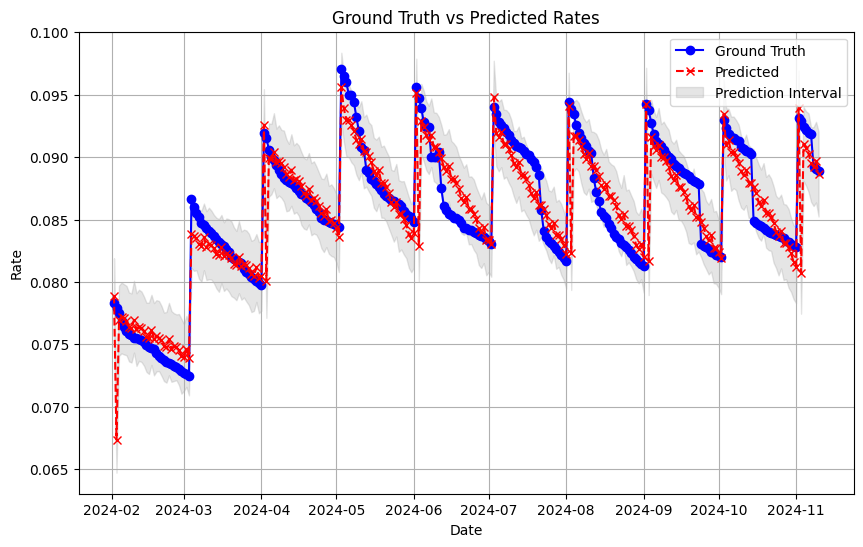

In [10]:
import numpy as np
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Assuming input_df is your DataFrame and holidays is already defined
# Base date and adding 'ds' column with sequential dates
input_df['date_balance'] = pd.to_datetime(input_df['date_balance'])

obs_df=input_df[input_df['date_balance']>=pd.to_datetime('2024-02-02')]

base_date = pd.to_datetime('2024-02-02')
obs_df['ds'] = obs_df['date_balance']

# Prepare the data for Prophet with 'rate' as the target variable and 'date_diff' as a regressor
df_prophet = obs_df[['ds', 'rate', 'date_diff']].rename(columns={'rate': 'y'})

# Initialize the Prophet model and add 'date_diff' as an additional regressor
model = Prophet(holidays=holidays)
model.add_regressor('date_diff')

# Split the data into train and test sets
train_size = int(len(df_prophet) * 0.8)
df_train = df_prophet[:train_size]
df_test = df_prophet[train_size:]

# Fit the Prophet model to the training data
model.fit(df_train)

# Create a future dataframe including 'date_diff' values for both train and test periods
future = model.make_future_dataframe(periods=len(df_test), freq='D')
future = future.merge(obs_df[['ds', 'date_diff']], on='ds', how='left')

# Make predictions
forecast = model.predict(future)

# Merge forecasted results with the actual 'rate' from the test set
comparison = forecast[['ds', 'yhat','yhat_lower','yhat_upper']].merge(obs_df[['ds', 'rate','date_diff']], on='ds', how='left')

# Calculate RMSE, MAE, MSE, MAPE
rmse = np.sqrt(mean_squared_error(comparison['rate'], comparison['yhat']))
mae = mean_absolute_error(comparison['rate'], comparison['yhat'])
mse = mean_squared_error(comparison['rate'], comparison['yhat'])

# Calculate MAPE
comparison['mape'] = np.abs((comparison['rate'] - comparison['yhat']) / comparison['rate']) * 100
mape = comparison['mape'].mean()

# Create a DataFrame for metrics results
metrics_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MSE', 'MAPE'],
    'Value': [rmse, mae, mse, mape]
})


# Plot comparison between ground truth (rate) and predicted (yhat)
plt.figure(figsize=(10, 6))
plt.plot(comparison['ds'], comparison['rate'], label='Ground Truth', color='blue', marker='o')
plt.plot(comparison['ds'], comparison['yhat'], label='Predicted', color='red', linestyle='--', marker='x')
plt.fill_between(comparison['ds'], comparison['yhat_lower'], comparison['yhat_upper'], color='gray', alpha=0.2, label='Prediction Interval')
plt.title('Ground Truth vs Predicted Rates')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.grid(True)
plt.show()

## Model Evaluation 

The plot above demonstrates that the model accurately captures the peak data points, including both the highest and lowest values of each monthly cycle.

In [11]:
metrics_df

,Metric,Value
0,RMSE,0.002198
1,MAE,0.001410
2,MSE,0.000005
3,MAPE,1.630817


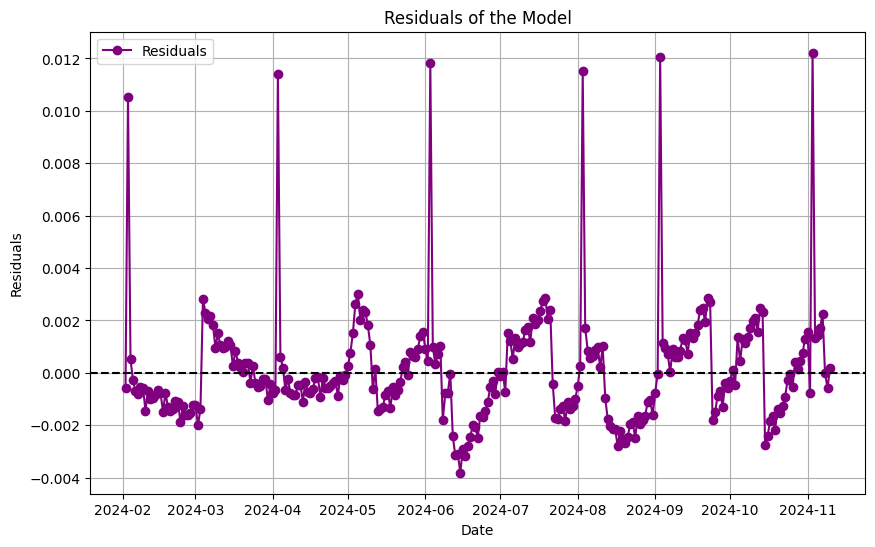

In [12]:
comparison['residuals'] = comparison['rate'] - comparison['yhat']
plt.figure(figsize=(10, 6))
plt.plot(comparison['ds'], comparison['residuals'], label='Residuals', color='purple', marker='o')
plt.title('Residuals of the Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

# Perform cross-validation (e.g., with a 30-day horizon)
df_cv = cross_validation(model, initial='180 days', period='30 days', horizon='30 days')

# Calculate performance metrics
df_p = performance_metrics(df_cv)
print(df_p)

  0%|          | 0/1 [00:00<?, ?it/s]

15:50:46 - cmdstanpy - INFO - Chain [1] start processing
15:50:46 - cmdstanpy - INFO - Chain [1] done processing


   horizon           mse      rmse       mae      mape     mdape     smape  \
0   3 days  9.361374e-06  0.003060  0.003042  0.035777  0.033691  0.035141   
1   4 days  1.022489e-05  0.003198  0.003187  0.037616  0.037955  0.036917   
2   5 days  8.957429e-06  0.002993  0.002989  0.035460  0.034735  0.034841   
3   6 days  9.400181e-06  0.003066  0.003064  0.036497  0.036800  0.035842   
4   7 days  8.099034e-06  0.002846  0.002836  0.033908  0.034735  0.033339   
5   8 days  7.521037e-06  0.002742  0.002731  0.032746  0.031251  0.032215   
6   9 days  7.972814e-06  0.002824  0.002802  0.033694  0.031251  0.033127   
7  10 days  7.805890e-06  0.002794  0.002768  0.033362  0.031251  0.032805   
8  11 days  7.991543e-06  0.002827  0.002804  0.033866  0.032762  0.033293   
9  12 days  5.924611e-06  0.002434  0.002424  0.029357  0.029192  0.028928   
10 13 days  5.837773e-06  0.002416  0.002405  0.029229  0.028808  0.028804   
11 14 days  4.476706e-06  0.002116  0.002103  0.025624  0.026116

In [14]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,9.361374e-06,0.003060,0.003042,0.035777,0.033691,0.035141,0.000000
1,4 days,1.022489e-05,0.003198,0.003187,0.037616,0.037955,0.036917,0.000000
2,5 days,8.957429e-06,0.002993,0.002989,0.035460,0.034735,0.034841,0.000000
3,6 days,9.400181e-06,0.003066,0.003064,0.036497,0.036800,0.035842,0.000000
4,7 days,8.099034e-06,0.002846,0.002836,0.033908,0.034735,0.033339,0.333333
5,8 days,7.521037e-06,0.002742,0.002731,0.032746,0.031251,0.032215,0.666667
6,9 days,7.972814e-06,0.002824,0.002802,0.033694,0.031251,0.033127,0.666667
7,10 days,7.805890e-06,0.002794,0.002768,0.033362,0.031251,0.032805,0.666667
8,11 days,7.991543e-06,0.002827,0.002804,0.033866,0.032762,0.033293,0.666667
9,12 days,5.924611e-06,0.002434,0.002424,0.029357,0.029192,0.028928,1.000000
